# Custom system with PyTorch

Aqua-blue provides functionality to create custom systems using other libraries such as `torch`. In this example, we will create an aqua-blue model with torch, and use a MLP (Multilayer Perceptron) to train the readout layer. 

## Example problem

We will be predicting the Lotka-Volterra system for this example. It is defined below -

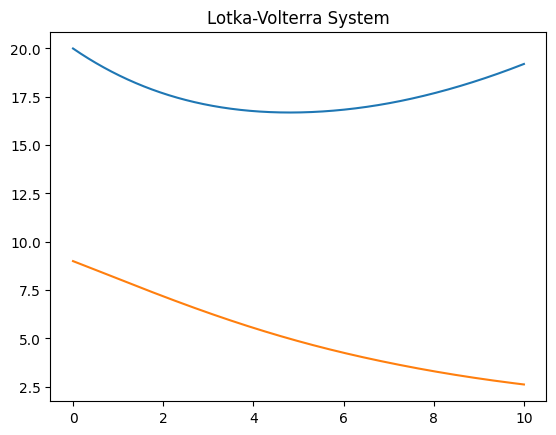

In [85]:
import torch
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def lotka_volterra(t, z, alpha, beta, delta, gamma):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]


def solve_lv(t_start, t_end, no, alpha=0.1, beta=0.02, gamma=0.3, delta=0.01, x0=20, y0=9):
    t_eval = np.linspace(t_start, t_end, no)
    solution = solve_ivp(lotka_volterra, [t_start, t_end], [x0, y0], t_eval=t_eval, args=(alpha, beta, delta, gamma))
    x, y = torch.Tensor(solution.y)
    lotka_volterra_array = torch.vstack((x, y)).T
    return lotka_volterra_array
    
y = solve_lv(0, 10, 1000)
t = np.linspace(0, 10, 1000)

plt.plot(t, y)
plt.title('Lotka-Volterra System')
plt.show()

## Aqua-blue Torch Model
The underlying mechanics do not change much (except for the readout), so all we need to do is perform the necessary casts to `torch.Tensor`.

### Reservoir

In [86]:
from dataclasses import dataclass
import aqua_blue

@dataclass
class DynamicalReservoirWithTorch(aqua_blue.reservoirs.DynamicalReservoir):
    
    def __post_init__(self):
        
        super().__post_init__()
        
        self.w_in = torch.tensor(self.w_in)
        self.w_res = torch.tensor(self.w_res)
        self.res_state = torch.tensor(self.res_state)
    
    def update_reservoir(self, input_state: torch.Tensor) -> torch.Tensor:
        
        self.res_state = (1.0 - self.leaking_rate) * self.res_state + self.leaking_rate * self.activation_function(
            self.w_in @ input_state + self.w_res @ self.res_state
        )
        return self.res_state

### TimeSeries

In [87]:
@dataclass
class TimeSeriesWithTorch(aqua_blue.time_series.TimeSeries):
    
    def __post_init__(self):
        super().__post_init__()
        self.dependent_variable = torch.tensor(self.dependent_variable)
        self.times = torch.tensor(self.times.astype(float))

### Model

In [88]:
@dataclass
class ModelWithTorch(aqua_blue.models.Model):
    
    def train(
        self,
        input_time_series: TimeSeriesWithTorch,
        warmup: int = 0
    ):
        
        time_series_array = input_time_series.dependent_variable
        independent_variables = torch.zeros((time_series_array.shape[0]-1, self.reservoir.reservoir_dimensionality))

        for i in range(independent_variables.shape[0]):
            independent_variables[i] = self.reservoir.update_reservoir(time_series_array[i])

        dependent_variables = time_series_array[1:]
        if warmup > 0:
            independent_variables = independent_variables[warmup:]
            dependent_variables = dependent_variables[warmup:]
        
        self.readout.train(independent_variables, dependent_variables)
        self.timestep = input_time_series.timestep
        self.final_time = input_time_series.times[-1]
        self.tz = input_time_series.times.tz
        self.times_dtype = input_time_series.times.dtype
        self.initial_guess = time_series_array[-1, :]

    def predict(self, horizon: int) -> TimeSeriesWithTorch:
        
        predictions = torch.zeros((horizon, self.reservoir.input_dimensionality), dtype=float)
        
        for i in range(horizon):
            if i == 0:
                predictions[i, :] = self.readout.reservoir_to_output(
                    self.reservoir.res_state
                )
                continue
            predictions[i, :] = self.readout.reservoir_to_output(
                self.reservoir.update_reservoir(predictions[i - 1, :])
            )
        
        if isinstance(self.final_time, float):
            assert isinstance(self.timestep, float)

        times_ = torch.arange(
            self.final_time + self.timestep,
            self.final_time + (horizon + 1) * self.timestep,
            self.timestep,
            dtype=float
        )

        return TimeSeriesWithTorch(
            dependent_variable=predictions,
            times=times_
        )


### MLP Readout

In [ ]:
import torch.nn as nn 
import torch.optim as optim 

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 1)  
        )
    
    def forward(self, x):
        return self.net(x)
    
@dataclass
class MLPReadoutWithTorch(aqua_blue.readouts.LinearReadout):
    
    def train(self, independent_variables: torch.Tensor, dependent_variables: torch.Tensor):
        pass

## Predictions

Let's use our new model to make predictions!

In [ ]:
import numpy as np

if torch.cuda.is_available():
    torch.set_default_device("cuda")
else:
    torch.set_default_device("cpu")

y = solve_lv(0, 10, 1000)
t = np.linspace(0, 10, 1000)

time_series = TimeSeriesWithTorch(dependent_variable=y, times=t)

normalizer = aqua_blue.utilities.Normalizer()
time_series = normalizer.normalize(time_series)

model = ModelWithTorch(
    reservoir=DynamicalReservoirWithTorch(
        reservoir_dimensionality=100,
        input_dimensionality=2,
        activation_function=torch.tanh
    ),
    readout=MLPReadoutWithTorch()
)
model.train(time_series)
model.readout.coefficients = torch.tensor(model.readout.coefficients)

prediction = model.predict(horizon=1_000)
prediction = normalizer.denormalize(prediction)

actual_future = solve_lv(prediction.times[0], prediction.times[-1], 1_000)

plt.plot(prediction.times, actual_future)
plt.xlabel('t')
plt.plot(prediction.times, prediction.dependent_variable)
plt.legend(['actual x', 'actual y', 'predicted x', 'predicted y'], shadow=True)
plt.title('Lotka-Volterra System')
plt.show()